# Пример использования ядер


для курса "Машинное обучение и анализ данных" https://github.com/Dyakonov/MLDM

автор: Александр Дьяконов https://dyakonov.org/ag/

In [6]:
import pandas as pd
import numpy as np
%pylab inline
plt.style.use('seaborn-dark')
import warnings
warnings.filterwarnings("ignore") # отключение варнингов
pd.set_option('display.max_columns', None) # pd.options.display.max_columns = None 
# pd.set_option('display.max_rows', None) # не прятать столбцы при выводе дата-фреймов
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rc('font', size=14)

Populating the interactive namespace from numpy and matplotlib


# скалярные произведения для последовательностей

In [2]:
x = "ACAGCAGTA"
z = "AGCAAGCGAG"

from collections import Counter

def phi(x):
    """
    пространство 3-подпоследовательностей
    """
    cnt = Counter()
    for i in range(len(x)-2):
        cnt[x[i: i+3]] += 1
    return dict(cnt)

phix = phi(x) # {'ACA': 1, 'CAG': 2, 'AGC': 1, 'GCA': 1, 'AGT': 1, 'GTA': 1}
phiz = phi(z) # {'AGC': 2, 'GCA': 1, 'CAA': 1, 'AAG': 1, 'GCG': 1, 'CGA': 1, 'GAG': 1}

def phidot(phix, phiz):
    """
    скалярное произведение в новом пространстве
    """
    return ({name: phix[name] * phiz[name] for name in set(phix.keys()) & set(phiz.keys())})

x_dot_y = phidot(phix, phiz) # {'GCA': 1, 'AGC': 2}
sum(list(x_dot_y.values())) # 3

3

# модельная задача

In [3]:
def gen_data(n_train=100, n_test=1001, e_error=0.5, random_seed=40):
    """
    данные для одномерной
    задачи регрессии
    """
    np.random.seed(random_seed)
    x = np.random.rand(n_train)
    e = e_error * np.random.rand(n_train)
    y = (3*(x - 0.6)) ** 3 + e # + x + e
    
    x2 = np.linspace(0, 1, n_test)
    y2 = (3*(x2 - 0.6)) ** 3 # + x2
    
    return (x, y, x2, y2)

x_train, y_train, x_test, y_test = gen_data()

In [4]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.linear_model import Ridge

def get_ridge(x, y, xx, degree, alpha=0.001, normalize=False):
    """
    ответы регрессии
    - на тесте
    - на обучении (недавно добавил)
    - коэффициенты регресии
    """
    poly = PolynomialFeatures(degree=degree)
    X = pd.DataFrame({'x': x})
    XX = pd.DataFrame({'x': xx})
    X = poly.fit_transform(X)
    XX = poly.fit_transform(XX)
    clf = Ridge(alpha=alpha, fit_intercept=True, normalize=normalize)
    clf.fit(X, y)
    a = clf.predict(XX)
    a_train = clf.predict(X)
    return (a, a_train, clf.coef_)

# пример полиномиальной регрессии

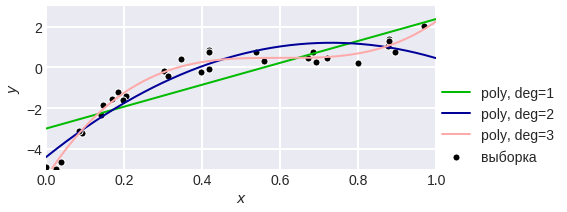

In [7]:
x, y, xx, yy = gen_data(n_train=30, n_test=1001, e_error=1, random_seed=1)

plt.figure(figsize=(7, 3))


plt.scatter(x, y, 50, 'black', label='выборка', zorder=3, edgecolors='white', linewidth=1.0)

plt.plot(xx, get_ridge(x, y, xx, degree=1, alpha=0, normalize=False)[0], lw=2, c='#00BB00', label='poly, deg=1', zorder=4)
plt.plot(xx, get_ridge(x, y, xx, degree=2, alpha=0, normalize=False)[0], lw=2, c='#000099', label='poly, deg=2', zorder=4)
plt.plot(xx, get_ridge(x, y, xx, degree=3, alpha=0, normalize=False)[0], lw=2, c='#FFAAAA', label='poly, deg=3', zorder=4)



plt.ylim([-5, 3])
plt.xlim([0, 1.0])
plt.grid(lw=2)

plt.xlabel(r'$x$')
plt.ylabel(r'$y$')

plt.legend(loc=(1,0))

# пример SVM

In [8]:
def show_scatter(f, g, y, size=20, figsize=(5, 4.5), eps=0.2, random=True,
                 xlabel='признак 1', ylabel='признак 2', lims=None, newfig=True,
                class1 = 'класс 1', class0='класс 0', show_legend=True):
    if newfig:
        fg = plt.figure(figsize=figsize)
    if random:
        # для легенды
        plt.scatter([], [], size, c='#000099', label=class1, edgecolors='white', linewidth=0.8)
        plt.scatter([], [], size, marker='s', c='#FF9999', label=class0, edgecolors='black', linewidth=0.5)
        for i in range(len(y)):
            if y[i]>0:
                plt.scatter([f[i]], [g[i]], size, c='#000099', edgecolors='white', linewidth=0.8)
            else:
                plt.scatter([f[i]], [g[i]], size, marker='s', c='#FF9999', edgecolors='black', linewidth=0.5)
                
    else:
        plt.scatter(f[y > 0], g[y > 0], size, c='#000099', label=class1, edgecolors='white', linewidth=0.8)
        plt.scatter(f[y <= 0], g[y <=0 ], size, marker='s', c='#FF9999', label=class0, edgecolors='black', linewidth=0.5)
    # plt.plot([],[],'k', label='модель')
    if lims is None:
        plt.xlim([min(f) - eps, max(f) + eps])
        plt.ylim([min(g) - eps, max(g) + eps])
    else:
        plt.xlim(lims[0])
        plt.ylim(lims[1])
    if show_legend:
        plt.legend(loc=(1,0))
    plt.grid(lw=2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if newfig:
        return fg
    
import numpy as np
import matplotlib.pyplot as plt


def plot_2d_separator(classifier, X, fill=False, twocolor=False, line=True, ax=None, eps=None):
    if eps is None:
        eps = 1.0 #X.std() / 2.
    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1001)
    yy = np.linspace(y_min, y_max, 1001)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0]
        fill_levels = [decision_values.min(), 0, decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5]
        fill_levels = [0, .5, 1]

    if ax is None:
        ax = plt.gca()
    if fill:
        c = decision_values.reshape(X1.shape)
        if twocolor:
            print (fill_levels)
            ax.contourf(X1, X2, c,
                        levels=fill_levels, colors=['#FF9999', '#0000FF'], alpha=0.2)
            ax.contour(X1, X2, c,
                       levels=np.linspace(c.min(), c.max(), 15), alpha=0.5, colors="white")             
            
        else:
            ax.contourf(X1, X2, c,
                        levels=np.linspace(c.min(), c.max(), 30), cmap=plt.cm.binary, alpha=0.5)
#         ax.contour(X1, X2, c,
#                     levels=np.linspace(c.min(), c.max(), 30), alpha=0.5, colors="white")        

    if line:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black")
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(()) 

<Figure size 216x216 with 0 Axes>

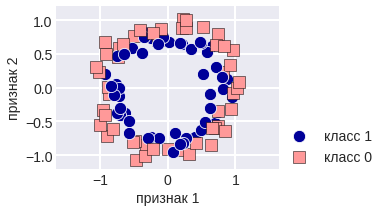

In [9]:
from sklearn.datasets import make_circles

plt.figure(figsize=(3, 3))
X, y = make_circles(noise=0.1, random_state=1)
#plt.scatter(X[:, 0], X[:, 1], 30, y)
show_scatter(X[:, 0], X[:, 1], y, size=150, eps=0.1, figsize=(4, 3), show_legend=True)
plt.axis('equal')
plt.xlabel("признак 1");
plt.ylabel("признак 2");

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=10, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
0.83
[-1.5073945807967382, 0, 1.5201936164645706]


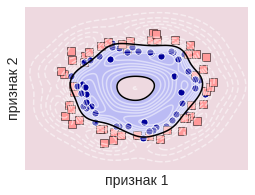

In [10]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', gamma=10)
svm.fit(X, y)

print (svm)
print (svm.score(X, y))


# визуализация
plt.figure(figsize=(4, 3));
plot_2d_separator(svm, X, fill=True, twocolor=True);
show_scatter(X[:, 0], X[:, 1], y, size=50, eps=0.5, figsize=(4, 3), show_legend=False, newfig=False);
